# Tutorial 6b: Parameter estimation by optimization

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">


*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t6b_parameter_estimation_by_optimization.ipynb).*

<br />

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import tqdm

import bebi103

import altair as alt

import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In this tutorial, we will continue our analysis of the data set from [Good, et al., 
 *Science*, **342**, 856-860, 2013](https://doi.org/10.1126/science.1243147).

## Exploratory data analysis

To start, let's make a quick plot of the spindle length versus droplet data, which you can download [here](../data/good_invitro_droplet_data.csv).

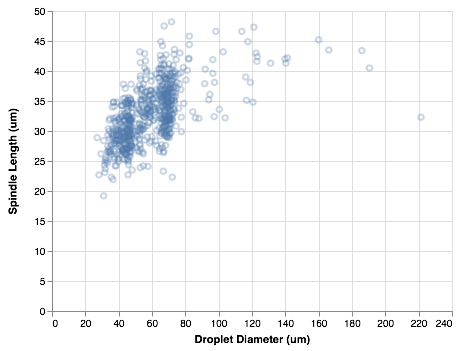

In [2]:
# Load in Data Frame
df = pd.read_csv('../data/good_invitro_droplet_data.csv', comment='#')

alt.Chart(df
    ).mark_point(
        opacity=0.3
    ).encode(
        x='Droplet Diameter (um):Q',
        y='Spindle Length (um):Q'
    )

Our objective is to use these data to obtain parameter estimates under two different models for spindle size. Remember, by "parameter estimation," we mean that we wish to compute a posterior distribution for the parameter set $\theta$, given the data. That is, we want to compute $g(\theta \mid d, l)$, where $d$ and $l$ are respectively the set of droplet diameters and spindle lengths. Beyond computing the posterior, we wish to obtain summaries of it.

## Models for spindle size

The parameter sets are defined by one of two models for spindle size. The first model, which we shall call the independent size model, posits that spindle size is independent of droplet size.  In this model

\begin{align}
l = \phi,
\end{align}

where $l$ is the measured length of the spindle and $\phi$ is the fixed spindle size.

We will call the second model the tubulin conservation model, the mathematical expression for which we derived in the [previous tutorial](t6a_model_generation_and_prior_predictive_checks.html).

\begin{align}
l(d;\gamma, \phi) = \frac{\gamma d}{(1 + (\gamma d/\phi)^3)^\frac{1}{3}},
\end{align}

where $d$ is the droplet diameter.

## The independent size model

The independent size model suggests that all spindles are the same size. As a reminder, in the previous tutorial, we came up with the following generative model.

\begin{align}
&\phi \sim \text{LogNorm}(\ln 20, 0.75),\\[1em]
&\sigma_0 \sim \text{Gamma}(2, 10),\\[1em]
&\sigma = \sigma_0\,\phi,\\[1em]
&l_i \sim \text{Norm}(\phi, \sigma).
\end{align}

The posterior for this model is $g(\phi, \sigma \mid l)$. We can code up the posterior and plot it using the distributions in the `scipy.stats` module.

### Plotting the posterior

We can directly plot the posterior. When doing so, we almost always work with the log posterior, and then exponentiate at the last moment. This means that probability densities that are multipled end up having their logarithms added. The distributions in the `scipy.stats` module have `logpdf` methods to facilitate this.

In [3]:
def log_post_indep_size(params, ell):
    """Log posterior for independent size spindle model"""
    # Make sure parameters are physical
    if (params < 0).any():
        return -np.inf
    
    # Unpack parameters
    phi, sigma_0 = params
    
    # Prior on phi
    log_prior = st.lognorm.logpdf(phi, 0.75, loc=0, scale=20)

    # Prior on sigma_0
    log_prior += st.gamma.logpdf(sigma_0, 2, loc=0, scale=1/10)
        
    # Likelihood
    log_like = np.sum(st.norm.logpdf(ell, phi, sigma_0*phi))
    
    return log_prior + log_like

This function gives the log posterior for a given value of $\phi$ and $\sigma_0$, given the data set $l$. Note that we make sure all parameters are positive. This is necessary in the case of $\sigma_0$ because the standard deviation of any distribution must be positive. For $\phi$, there is no mathematical reason why it must be positive, but physically we cannot have negative spindle lengths. 

Note also that $\phi$ and $\sigma_0$ are passed in as an array and unpacked. The reasons why this is convenient will be clear later. 

We need to compute the log posterior for every value of $\phi$ and $\sigma_0$ we are interested in, so we need to grid up values of $\phi$ and $\sigma_0$ we wish to plot.

In [4]:
# Set up plotting range
phi = np.linspace(32, 33.5, 200)
sigma0 = np.linspace(0.125, 0.165, 200)
PHI, SIGMA0 = np.meshgrid(phi, sigma0)

We can not compute the posterior for each point in the grid. Note that we are not actually computing the posterior, but something proportional to it. To handle underflow issues, we set the maximum computed value of the (unnormalized) log posterior to be zero, and then exponentiate to get the unnormalized, but not underflowed, posterior.

In [5]:
# Slice out spindle lengths as numpy array for speed
ell = df['Spindle Length (um)'].values

# Compute log posterior
LOG_POST = np.empty_like(PHI)
for i in tqdm.tqdm(range(PHI.shape[0])):
    for j in range(PHI.shape[1]):
        LOG_POST[i, j] = log_post_indep_size(
                            np.array([PHI[i, j], SIGMA0[i,j]]), ell)
        
# Exponentiate. Ignore normalization, so set max LOG_POST to zero
POST = np.exp(LOG_POST - LOG_POST.max())

100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


Now we can plot the posterior.

In [6]:
# Make plot
p = bebi103.viz.contour(PHI,
                        SIGMA0,
                        POST,
                        x_axis_label='φ (µm)',
                        y_axis_label='σ₀',
                        title='Posterior for independent size model',
                        overlaid=True)
bokeh.io.show(p)

### Estimation of the MAP parameters

The plot of the posterior gives most of the information we need about it. It displays the what values of $\phi$ and $\sigma_0$ are most likely and how they covary. We may want to summarize the posterior with a few numbers. A commonly used approach is to find the parameter values that maximize the posterior, or the **maximum a posteriori**, or MAP, parameter values. Note that in doing this, you are reducing all of the posterior information to a single point. You lose pretty much all of the information about the shape of the posterior. I generally do not advice finding the MAP, but this is very commonly done, so I show you here how to approach this problem.

Finding the MAP amounts to an **optimization problem** in which we find the arguments (parameters) for which a function (the posterior distribution) is maximal. It is often much easier to find the maximum for the *logarithm* of the posterior. Since the logarithm function is monotonic, a maximum of the log posterior is also a maximum of the posterior. Fortunately, we have already coded up the log posterior.

`scipy.optimize.minimize()` offers many options for algorithms, which you can read about in the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).  I find that [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) tends to work well.  It does not rely on derivative information, so discontinuities don't hurt.  That is important for the present example because we have hard bounds on $p$.  We could use constrained optimizers such as L-BFGS-B or COBYLA, but Powell's method generally suffices.  It is sometimes slow, though.
 
Now, the optimizers offered by `scipy.optimize.minimize()` find *minimizers*, so we need to define our objective function as the *negative* log posterior.

In [7]:
def neg_log_post_indep_size(params, ell):
    return -log_post_indep_size(params, ell)

Next, we have to provide an initial guess for parameter values. The optimization routine only finds a *local* maximum and is not in general guaranteed to converge. Therefore, the initial guess can be very important. Looking at the data, we would expect $\phi$ to be somewhere around 35 µm and for $\sigma$ to be 7 µm, putting $\sigma_0$ to be about 0.15. We will store these results in an array.

In [8]:
params_0 = np.array([35, 0.15])

We are now ready to use `scipy.optimize.minimze()` to compute the MAP.  We use the `args` kwarg to pass in the other arguments to the `neg_log_post_indep_size()` function.  In our case, these arguments are the data points.  The `minimize()` function returns an object that has several attributes about the resulting optimization. Most important is `x`, the optimal parameter values.

In [9]:
# Extra arguments as a tuple (note the trailing comma; must be tuple)
args = (df['Spindle Length (um)'].values,)

# Compute the MAP
res = scipy.optimize.minimize(neg_log_post_indep_size, 
                              params_0,
                              args=args,
                              method='powell')

# Extract optimal parameters
popt = res.x

# For convenience...
phi_MAP, sigma_0_MAP = popt

# Print results
print("""
Most probable parameters
------------------------
φ = {0:.2f} µm
σ₀ = {1:.3f}
""".format(phi_MAP, sigma_0_MAP))

/Users/Justin/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)



Most probable parameters
------------------------
φ = 32.86 µm
σ₀ = 0.146



We have successfully found the MAP which provides just that; the maximally probable parameter values. But with just the MAP value, we know nothing about the posterior probability density function, $g(\phi, \sigma_0\mid y)$, which is what we want to characterize. Can we find an approximate expression for the posterior that is more tractable to treat to give an error bar for these parameters?

### Gaussian approximation of the posterior

If we have an expression for the posterior, we can write an approximate posterior that is easier to work with. Specifically, we will perform a multidimensional Taylor series expansion of the log posterior to give (in this case) a two-dimensional Gaussian.  In general, for a set of parameters $\theta$, where $\theta^*$ is the most probable set of parameter values, the approximation to give a Gaussian log posterior is

\begin{align}
\ln g(\theta\mid y) \approx \text{constant} + \frac{1}{2}\left(\theta - \theta^*\right)^T \cdot \mathsf{B} \cdot \left(\theta - \theta^*\right),
\end{align}

where $\mathsf{B}$ is the symmetric **Hessian matrix** of second derivatives,

\begin{align}
B_{ij} = \left.\frac{\partial^2\,\ln g(\theta\mid y)}{\partial \theta_i\,\partial \theta_j}\right|_{\theta = \theta^*}.\\[0.1em] \nonumber
\phantom{blah}
\end{align}

Because we are evaluating the second derivatives at the point of maximal posterior probability, the Hessian is positive definite and therefore invertible. Its negative inverse is the **covariance matrix**, $\mathsf{\Sigma}$, of the Gaussian approximation of the posterior..

So, to compute the Gaussian approximation of the posterior, our task is two-fold.  First, find the parameter values that give the maximal posterior probability, which we have already done.  Second, compute the Hessian of the log posterior at the MAP and invert it to get your covariance matrix.  Note that the covariance matrix is **not** the inverse of every element of the Hessian; it is the inverse of the Hessian matrix.  The error bars for each parameter are then given by the diagonal elements of the covariance matrix.

To compute the covariance matrix, we need to compute the Hessian of the log of the posterior at the MAP.  We will do this numerically using the `statsmodels.tools.numdiff` module, which we imported as `smnd`. We use the function `smnd.approx_hess()` to compute the Hessian at the optimal parameter values. Note that since we already have the log posterior coded up and the MAP parameter values, we can just directly shove these into the numerical Hessian calculator.

In [10]:
hes = smnd.approx_hess(popt, log_post_indep_size, args=args)

Now that we have the Hessian, we take its negative inverse to get the covariance matrix.

In [11]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
cov

array([[ 3.41434219e-02, -1.51731168e-04],
       [-1.51731168e-04,  1.64566486e-05]])

The diagonal terms give the approximate variance in the  regression parameters.  The off-diagonal terms give the covariance, which describes how the parameters relate to each other.  Nonzero covariance indicates that they are not completely independent.

We can now report our error bars with the measured covariance.

In [12]:
# Report results
print("""
Results for conserved tubulin model (≈ 68% of total probability)
----------------------------------------------------------------
φ = {0:.2f} ± {1:.2f} µm
σ₀ = {2:.3f} ± {3:.3f}
""".format(phi_MAP, np.sqrt(cov[0,0]), sigma_0_MAP, np.sqrt(cov[1,1])))


Results for conserved tubulin model (≈ 68% of total probability)
----------------------------------------------------------------
φ = 32.86 ± 0.18 µm
σ₀ = 0.146 ± 0.004



The error bars as we have reported them constitute an approximate **credible region**. The α-percent Bayesian credible region defines a region of parameter space in which the parameter has probability α/100 of lying. This is different form a frequentist confidence interval, though the latter is often erroneously interpreted as the former.

Note also that we can use the ± notation here because we are approximating the posterior as Gaussian and the credible region is therefore necessarily symmetric.

To assess how close the Gaussian approximation is to the posterior, let's plot the Gaussian approximation and the exact marginalized posterior on the same contour plot. We can use `scipy.stats.multivariate_normal.pdf()` function to generate the PDF for the Gaussian approximation.

In [13]:
# Multivariate Gaussian
post_gauss = np.empty_like(PHI)
for i in tqdm.tqdm(range(PHI.shape[0])):
    for j in range(PHI.shape[1]):
        post_gauss[i, j] = st.multivariate_normal.pdf(
                            (PHI[i, j], SIGMA0[i, j]), popt, cov)
        
# Make contours
p = bebi103.viz.contour(PHI,
                        SIGMA0,
                        POST,
                        x_axis_label='γ',
                        y_axis_label='φ (µm)')
p = bebi103.viz.contour(PHI,
                        SIGMA0,
                        post_gauss,
                        line_color='slategray',
                        p=p)
bokeh.io.show(p)

100%|██████████| 200/200 [00:05<00:00, 34.65it/s]


The Gaussian approximation is not that far off from the posterior, especially at the peak. **This is not always the case!** You should always check your posterior after you find the MAP to make sure there is nothing pathological going on. Actually, you really should just avoid MAP finding and then doing the Gaussian approximation of the posterior. The only real advantage is that for problems with not too many parameters, the calculation is fast.

## The tubulin conservation model

Let us now consider the tubulin conservation model. Recalling the [previous tutorial](t6a_model_generation_and_prior_predictive_checks.html), the generative model is

\begin{align}
&\phi \sim \text{LogNorm}(\ln 20, 0.75),\\[1em]
&\gamma \sim \text{Beta}(2, 2), \\[1em]
&\sigma_0 \sim \text{Gamma}(2, 10),\\[1em]
&\sigma = \sigma_0\,\phi,\\[1em]
&\mu =  \frac{\gamma d_i}{\left(1+(\gamma d_i/\phi)^3\right)^{\frac{1}{3}}}, \\[1em]
&l_i \sim \text{Norm}(\mu, \sigma) \;\forall i.
\end{align}

We can code up the log posterior for this one as well.

In [14]:
def log_post_cons_tubulin(params, d, ell):
    """Log posterior for conserved tubulin model."""
    if (params < 0).any():
        return -np.inf
    
    # Unpack parameters
    phi, gamma, sigma_0 = params
    
    # Prior on phi
    log_prior = st.lognorm.logpdf(phi, 0.75, loc=0, scale=20)

    # Prior on gamma
    log_prior += st.beta.logpdf(gamma, 2, 2)
    
    # Prior on sigma_0
    log_prior += st.gamma.logpdf(sigma_0, 2, loc=0, scale=1/10)
    
    # Theoretical spindle length
    mu = gamma * d / np.cbrt(1 + (gamma * d / phi)**3)
        
    # Likelihood
    log_like = np.sum(st.norm.logpdf(ell, mu, sigma_0*phi))
    
    return log_prior + log_like

### Compute the MAP and Gaussian-approximation credible region

For reasons that will become clear in a moment, let's find the MAP and credible region first. I do the entire calculation in the cod ecell below because it is exactly the same as for the droplet diameter independent model. We take the following steps.

1. Define the negative log posterior function.
2. Set up the `args` that need to be passed to the log posterior function.
3. Provide an inital guess for the solver.
4. Use `scipy.optimize.minimize()` to find the MAP.
5. Extract the optimal parameters from the output.
6. Compute the Hessian.
7. Compute the covariance.
8. Report the results.

Because we will use Stan later, to make a direct comparison, we will use the BFGS algorithm for this particular optimization.

In [15]:
def neg_log_post_cons_tubulin(params, d, ell):
    return -log_post_cons_tubulin(params, d, ell)

params_0 = np.array([35, 0.8, 0.15])

# Extra arguments as a tuple (note the trailing comma; must be tuple)
args = (df['Droplet Diameter (um)'].values, df['Spindle Length (um)'].values)

# Compute the MAP
res = scipy.optimize.minimize(neg_log_post_cons_tubulin, 
                              params_0,
                              args=args,
                              method='BFGS')

# Extract optimal parameters
popt = res.x

# Compute Hessian and covariance matrix
hes = smnd.approx_hess(popt, log_post_cons_tubulin, args=args)
cov = -np.linalg.inv(hes)

# For convenience...
phi_MAP, gamma_MAP, sigma_0_MAP = popt

# Print results
print("""
Most probable parameters
------------------------
φ = {0:.2f} ± {1:.2f} µm
γ = {2:.3f} ± {3:.3f}
σ₀ = {4:.3f} ± {5:.3f}
""".format(phi_MAP, np.sqrt(cov[0, 0]), 
           gamma_MAP, np.sqrt(cov[1, 1]), 
           sigma_0_MAP, np.sqrt(cov[2, 2])))


Most probable parameters
------------------------
φ = 38.27 ± 0.39 µm
γ = 0.859 ± 0.017
σ₀ = 0.098 ± 0.003



### Plotting the (marginalized) posterior

Plotting this distribution is harder than in the independent size model because we now have three parameters. We therefore have to marginalize out one of the parameters to make a contour plot of two parameters we are interested in. To do so, we first need to grid up the parameter values and compute the log posterior. 

Note that this problem of computing the posterior does not scale well. For the previous model, we evaluated the posterior at 200 $\phi$ values and 200 $\sigma_0$ values for a total of 40,000 posterior evaluations. It took a few seconds to run. Now, we will evaluate the posterior at 100 $\phi$ values, 100 $\gamma$ values, and 100 $\sigma_0$ values, for a total of a million posterior evaluations, and you can expect the calculation in the next cell to take several minutes. If we had any more parameters, this brute force style of posterior evaluation becomes intractable. Furthermore, notice below that I chose a tight range of parameter values. I was able to do this because I already found the MAP and credible regions first. Without this, the posterior would be mostly a big sea of low probability and finding where it is not is like finding a needle in a haystack.

In [16]:
# Set up plotting range
phi = np.linspace(37, 40, 100)
gamma = np.linspace(0.78, 0.92, 100)
sigma0 = np.linspace(0.085, 0.11, 100)
PHI, GAMMA, SIGMA0 = np.meshgrid(phi, gamma, sigma0)

# Slice out data as numpy array for speed
d = df['Droplet Diameter (um)'].values
ell = df['Spindle Length (um)'].values

# Compute log posterior
LOG_POST = np.empty_like(PHI)
for i in tqdm.tqdm(range(PHI.shape[0])):
    for j in range(PHI.shape[1]):
        for k in range(PHI.shape[2]):
            LOG_POST[i, j, k] = log_post_cons_tubulin(
                    np.array([PHI[i,j,k], GAMMA[i,j,k], SIGMA0[i,j,k]]), d, ell)
        
# Exponentiate. Ignore normalization, so set max LOG_POST to zero
POST = np.exp(LOG_POST - LOG_POST.max())

100%|██████████| 100/100 [10:59<00:00,  6.92s/it]


To plot the marginalized posterior $g(\phi, \gamma\mid d, l)$, which is what we are interested in, we need to marginalize over $\sigma_0$. We can do so numerically using `np.trapz()`, integrating over the $\sigma_0$ values.

In [17]:
# Compute marginalized posterior
POST_marginalized = np.trapz(POST, x=sigma0, axis=2)

# Plot
p = bebi103.viz.contour(PHI[:,:,0],
                        GAMMA[:,:,0],
                        POST_marginalized,
                        x_axis_label='φ (µm)',
                        y_axis_label='γ',
                        title='Marg. posterior for conserved tubulin model',
                        overlaid=True)
bokeh.io.show(p)

### Displaying the best fit line

Researchers typically display the best-fit line with their data points. I generally discourage this; you should show a *set* of lines sampled out of the posterior. However, for now we do not know how to do that (you'll use MCMC to do it), so we will just display the best fit line.

In [18]:
# Extract parameters
phi, gamma = popt[:2]

# Make theoretical curve
d_theor = np.linspace(0, 250, 250)
ell_theor = gamma * d_theor / np.cbrt(1 + (gamma * d_theor / phi)**3)

# Make the plot
p = bokeh.plotting.figure(height=200, width=400, 
                          x_axis_label='droplet diameter (µm)',
                          y_axis_label='spindle length (µm)')
p.circle(source=df, 
         x='Droplet Diameter (um)',
         y='Spindle Length (um)', 
         alpha=0.3)
p.line(d_theor, ell_theor, color='orange', line_width=2)

bokeh.io.show(p)

It looks like most of the sampling was in the curved part of the plot, meaning we had few samples in the linear regime where the only relevant parameter is $\gamma$, and few in the regime where $\phi$ is the only relevant parameter.

## Finding the MAP with Stan

We have thus far used Stan to generate prior predictive samples. Now, we will use Stan to specify a model and then find the MAP parameter values. I will again show the model below (and again remind you that you should have your Stan models as separate files; I just show it here so that the notebook is self-contained), and then discuss the syntax.

In [19]:
model_code = """
functions {
  real ell_theor(real d, real phi, real gamma) {
    real denom_ratio = (gamma * d / phi)^3;
    return gamma * d / (1 + denom_ratio)^(1.0 / 3.0); 
  }
}


data {
  int N;
  real phi_mu;
  real phi_sigma;
  real gamma_alpha;
  real gamma_beta;
  real sigma_0_alpha;
  real sigma_0_beta;
  real d[N];
  real ell[N];
}


parameters {
  real<lower=0> phi;
  real<lower=0, upper=1> gamma;
  real<lower=0> sigma_0;
}


transformed parameters {
  real sigma = sigma_0 * phi;
}


model {
  // Priors
  phi ~ lognormal(phi_mu, phi_sigma);
  gamma ~ beta(gamma_alpha, gamma_beta);
  sigma_0 ~ gamma(sigma_0_alpha, sigma_0_beta);
  
  // Likelihood
  for (i in 1:N) {
    ell[i] ~ normal(ell_theor(d[i], phi, gamma), sigma); 
  }
}
"""

The `functions` block is as before in the [previous tutorial](t6a_model_generation_and_prior_predictive_checks.html). The `data` block again contains the values we use for the prior. It is also acceptable to hard-code these into the Stan mode, which is what we did above when we specified the log posterior using the `scipy.stats` module. Additionally in the `data` block, we have the measured data for the droplet diameters and the spindle lengths.

New to this program is the `parameters` block. Here we are specifying what the parameters are for the model. These are the parameters that the posterior distribution depends on. Note that I have provided their bounds in their declations. Usually, the `parameters` block just has the declarations of the type and bounds and dimension of the model parameters.

Next, the `transformed parameters` block contains any variable transformations that are convenient to make.

Finally, the `model` block is a statement of the generative model. The `~` symbol enables concise statements of how parameters (and data) are distributed.

Now that we have our model in place, we can compile it.

In [27]:
sm = bebi103.stan.StanModel(model_code=model_code)

Using cached StanModel.


The `StanModel` instance has several methods, including `sm.optimizing()`, which will find the MAP for you using a BFGS algorithm. Let's give it a shot.

In [26]:
data = dict(N=len(df),
            phi_mu=np.log(20),
            phi_sigma=0.75,
            gamma_alpha=2.0,
            gamma_beta=2.0,
            sigma_0_alpha=2.0,
            sigma_0_beta=10.0,
            d=df['Droplet Diameter (um)'].values,
            ell=df['Spindle Length (um)'].values)

# Find the MAP
sm.optimizing(data=data)

OrderedDict([('phi', array(38.26959671)),
             ('gamma', array(0.85864393)),
             ('sigma_0', array(0.09812094)),
             ('sigma', array(3.75504896))])

We get exactly the same MAP as we got using Scipy. The big benefit of using Stan for MAP finding is that, as a probabilistic programming langauge, it is often easier to code up your generative models (at least for more complicated ones). The problem is that Stan currently does not enable calculations of the Hessian so you cannot get the Gaussian-approximate credible region. For that reason, and because doing MAP calculations in general is not terribly useful, I do not really advocate using Stan for finding the MAP. I introduced it here to make you aware of the how to construct a Stan model. And also to give you a ...

### Sneak peak at how Stan can sampled posteriors

Recall when we did hacker stats that we could learn a lot about a distribution by sampling out of it. As we will discuss extensively in coming weeks, Stan can sample out of posterior distributions. Let's do it and then use the nifty `bebi103.viz.corner()` function to display the samples.

In [23]:
samples = sm.sampling(data=data)

bokeh.io.show(bebi103.viz.corner(samples, pars=['phi', 'gamma', 'sigma_0'], alpha=0.05))

Look at that! We can very quickly sample and generate plots of the marginal posterior distributions! We will be discussing this for the next few weeks, but just looking at that, and how fast the calculation was, especially compared to your brute-force plotting, I'm sure you are excited to start using Stan for your statistical inference.

## Computing environment

In [24]:
%load_ext watermark

In [25]:
%watermark -v -p numpy,pandas,scipy,tqdm,statsmodels,pystan,altair,bokeh,bebi103,jupyterlab

CPython 3.7.0
IPython 7.1.1

numpy 1.15.4
pandas 0.23.4
scipy 1.1.0
tqdm 4.28.1
statsmodels 0.9.0
pystan 2.17.1.0
altair 2.2.2
bokeh 1.0.1
bebi103 0.0.40
jupyterlab 0.35.3
